<div style="background-color:white;" >
<div style="clear: both; display: table;">
  <div style="float: left; width: 14%; padding: 5px; height:auto">
    <img src="img/TUBraunschweig_CO_200vH_300dpi.jpg" alt="TU_Braunschweig" style="width:100%">
  </div>
  <div style="float: left; width: 28%; padding: 5px; height:auto">
    <img src="img/TU_Clausthal_Logo.png" alt="TU_Clausthal" style="width:100%">
  </div>
  <div style="float: left; width: 25%; padding: 5px; height:auto">
    <img src="img/ostfalia.jpg" alt="Ostfalia" style="width:100%">
  </div>
  <div style="float: left; width: 21%; padding: 5px;">
    <img src="img/niedersachsen_rgb_whitebg.png" alt="Niedersachsen" style="width:100%">
  </div>
  <div style="float: left; width: 9%; padding: 5px;">
    <img src="img/internet_BMBF_gefoerdert_2017_en.jpg" alt="bmbf" style="width:100%">
  </div>
</div>
<div style="text-align:center">
<img src="img/ki4all.jpg" alt="KI4ALL-Logo" width="200"/>
</div>
</div>

# Synthetic Biomedical Data – Lesson 4: Non-Causal Variation
Part of the *Microcredit Synthetic Biomedical Data*.

➡️ [Back to Lesson 4b: Generating Non-Causal Variation](04b_non_causal_variation_generating.ipynb)
➡️ [Module README](../README.md)

*Before continuing, please ensure you reviewed the prerequisites and learning goals in Lesson 1.*


# Lesson 4c: Use Cases & Applications

### Why this lesson matters

You've learned **how** to generate synthetic biomedical data with controlled properties. But a critical question remains:

**Why go through all this effort? Why not just use real data?**

This lesson answers that question by demonstrating **four concrete use cases** where synthetic data is not just useful, but essential.

### The fundamental advantage

Synthetic data gives you something real data never can: **known ground truth**.

- You know exactly which features are informative
- You know the true confounding structure
- You can generate edge cases that are rare in reality
- You can share data without privacy concerns
- You can create unlimited variations for testing

### What you'll learn

After completing this notebook, you will understand:
- When to use synthetic data in your research
- How synthetic data helps detect hidden problems in methods
- Why synthetic data is essential for education and training
- How to use synthetic data for study design and planning
- The role of synthetic data in algorithm development

### Structure

We'll explore four key use cases:
1. **Method Testing**: Can your algorithm handle confounding?
2. **Education & Training**: Learning without patient data
3. **Study Design**: Planning before data collection
4. **Algorithm Development**: Testing edge cases safely

# Setup

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from biomedical_data_generator import BatchEffectsConfig, ClassConfig, DatasetConfig, generate_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Reproducibility
rng = np.random.default_rng(42)

# Use Case 1: Method Testing

## The Problem

Imagine you develop a new machine learning method for biomarker discovery. How do you know if it:
- Actually finds biological signal vs. just batch effects?
- Works when classes are partially confounded with sites?
- Generalizes to new hospitals/labs?

**With real data:** You'll never know for sure. You don't know which features are "truly" informative vs. artifacts.

**With synthetic data:** You have perfect ground truth. You can test exactly what you want.

## Demonstration: The Hidden Failure

Let's show how a "successful" method can actually be learning artifacts.

In [38]:
# Generate confounded data (high confounding)
cfg_confounded = DatasetConfig(
    n_informative=10,
    n_noise=500,
    class_configs=[
        ClassConfig(n_samples=100, label="healthy"),
        ClassConfig(n_samples=100, label="diseased"),
    ],
    class_sep=[1.5],  # Strong biological signal
    batch_effects=BatchEffectsConfig(
        n_batches=3,
        confounding_with_class=0.7,  # High confounding
        effect_type="additive",
        effect_strength=0.5,
    ),
    random_state=42,
)

x_conf, y_conf, meta_conf = generate_dataset(cfg_confounded)
batch_conf = meta_conf.batch_labels

print("Generated confounded dataset:")
print(f"  Shape: {x_conf.shape}")
print(f"  True informative features: {len(meta_conf.informative_idx)}")
print(f"  Noise features: {len(meta_conf.noise_idx)}")
print(f"  Batches: {np.unique(batch_conf)}")
print("\n  Confounding level: 0.7 (high)")

Generated confounded dataset:
  Shape: (200, 510)
  True informative features: 10
  Noise features: 500
  Batches: [0 1 2]

  Confounding level: 0.7 (high)


In [39]:
# Test a simple classifier with TWO evaluation strategies

model = Pipeline([("scaler", StandardScaler()), ("classifier", LogisticRegression(max_iter=1000, random_state=42))])

# Strategy 1: Standard random CV (common in publications)
cv_random = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores_random = cross_val_score(model, x_conf, y_conf, cv=cv_random, scoring="accuracy")

# Strategy 2: Group CV (respects batch structure)
cv_group = GroupKFold(n_splits=3)
scores_group = cross_val_score(model, x_conf, y_conf, groups=batch_conf, cv=cv_group, scoring="accuracy")

print("Testing a Logistic Regression classifier")
print("=" * 50)
print(f"Random CV (standard):      {scores_random.mean():.3f} ± {scores_random.std():.3f}")
print(f"Group CV (leave-one-batch-out): {scores_group.mean():.3f} ± {scores_group.std():.3f}")
print()
print(f"Performance gap: {scores_random.mean() - scores_group.mean():.3f}")
print()
print("❌ Random CV says: 'Great model!'")
print("✅ Group CV reveals: 'Model fails on new batches!'")

Testing a Logistic Regression classifier
Random CV (standard):      0.905 ± 0.029
Group CV (leave-one-batch-out): 0.573 ± 0.284

Performance gap: 0.332

❌ Random CV says: 'Great model!'
✅ Group CV reveals: 'Model fails on new batches!'


### Why This Matters

**Without synthetic data:**
- You'd publish the random CV result (looks great!)
- Deploy the model in a new hospital
- Model completely fails
- You don't know why (no ground truth)

**With synthetic data:**
- You test both CV strategies
- Immediately see the problem
- Know the model is learning batch artifacts
- Can fix the issue before publication

### Key Insight

> **Synthetic data lets you discover problems that would be invisible in real data.**

This is why method developers should test on synthetic data with known confounding levels.

# Use Case 2: Education & Training

## The Problem

Teaching data science for biomedicine faces unique challenges:
- **Privacy**: Can't share real patient data with students
- **No ground truth**: Students never know if their answer is correct
- **Limited scenarios**: Real datasets don't cover all failure modes
- **Resource access**: Not all institutions have biomedical data

## How Synthetic Data Solves This

### 1. Privacy-Free Learning
- Generate unlimited datasets without ethics approval
- Students can experiment freely
- Share code and data openly

### 2. Known Ground Truth
- Students can check: "Did I find the informative features?"
- Objective assessment of methods
- Immediate feedback on mistakes

### 3. Controlled Difficulty
Generate progressive challenges:
- Lesson 1: No confounding, easy
- Lesson 2: Moderate confounding
- Lesson 3: Extreme edge cases

## Example: Create an Exercise

**Task**: "Find the informative features in this dataset"


In [40]:
# Generate educational dataset
cfg_edu = DatasetConfig(
    n_informative=5,
    n_noise=20,
    class_configs=[
        ClassConfig(n_samples=80, label="control"),
        ClassConfig(n_samples=80, label="disease"),
    ],
    class_sep=[1.2],
    random_state=42,
)

X_edu, y_edu, meta_edu = generate_dataset(cfg_edu)

print("Educational Dataset")
print("=" * 50)
print(f"Shape: {X_edu.shape}")

Educational Dataset
Shape: (160, 25)


In [41]:
print(f"\nStudent sees: A dataset with {X_edu.shape[1]} features")
print("Student's task: Identify which features are informative")
print("\nGround truth (hidden from student):")
print(f"  Informative features: {meta_edu.informative_idx}")
print(f"  Noise features: {meta_edu.noise_idx[0]}...{meta_edu.noise_idx[-1]}")
print("\n✓ Results can be checked against ground truth!")


Student sees: A dataset with 25 features
Student's task: Identify which features are informative

Ground truth (hidden from student):
  Informative features: [0, 1, 2, 3, 4]
  Noise features: 5...24

✓ Results can be checked against ground truth!


# Use Case 3: Study Design & Planning

## The Problem

Planning a multi-center biomarker study:
- How many sites do we need?
- How many samples per site?
- Can we tolerate some recruitment bias?
- What if one site has different instruments?

**Without synthetic data:** Collect expensive data first, discover problems later.

**With synthetic data:** Simulate different scenarios before data collection.

## Example: Planning a Multi-Site Study

Scenario: You're designing a 3-site study for a biomarker panel. Site 1 tends to recruit more cases than controls (recruitment bias).

**Question**: How much does this hurt performance?


In [42]:
# Simulate different study designs
designs = {
    "Balanced recruitment\n(ideal)": 0.0,
    "Slight bias\n(acceptable?)": 0.3,
    "Moderate bias\n(realistic?)": 0.6,
    "Strong bias\n(problem!)": 0.9,
}

results = []

print("Simulating Study Designs")
print("=" * 60)

for design_name, confounding_level in designs.items():
    # Simulate this study design
    cfg = DatasetConfig(
        n_informative=10,
        n_noise=40,
        class_configs=[
            ClassConfig(n_samples=100, label="healthy"),
            ClassConfig(n_samples=100, label="diseased"),
        ],
        class_sep=[1.5],
        batch_effects=BatchEffectsConfig(
            n_batches=3,
            confounding_with_class=confounding_level,
            effect_type="additive",
            effect_strength=0.5,
        ),
        random_state=42,
    )

    x, y, meta = generate_dataset(cfg)

    # Evaluate generalization to new sites
    model = Pipeline([("scaler", StandardScaler()), ("classifier", LogisticRegression(max_iter=1000, random_state=42))])

    cv = GroupKFold(n_splits=3)
    scores = cross_val_score(model, x, y, groups=meta.batch_labels, cv=cv, scoring="accuracy")

    results.append(scores.mean())
    print(f"{design_name:30s}: {scores.mean():.3f} ± {scores.std():.3f}")

Simulating Study Designs
Balanced recruitment
(ideal)  : 0.965 ± 0.026
Slight bias
(acceptable?)     : 0.923 ± 0.067
Moderate bias
(realistic?)    : 0.899 ± 0.061
Strong bias
(problem!)        : 0.654 ± 0.198


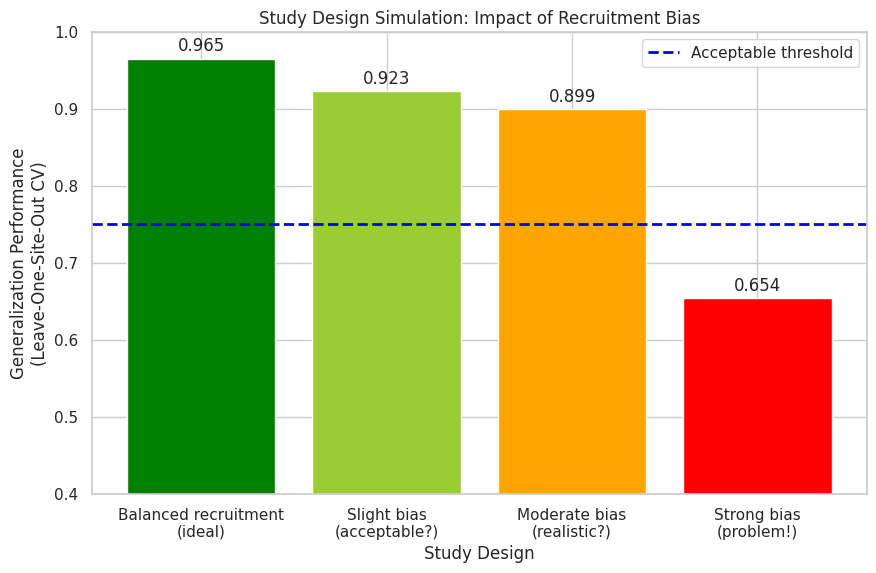


✓ Decision: Can tolerate up to 0.3 confounding
✓ Action: Implement strict recruitment protocols at sites
✓ Savings: Discovered issue before expensive data collection


In [43]:
# Visualize study design simulation
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(range(len(results)), results, color=["green", "yellowgreen", "orange", "red"])
ax.set_ylabel("Generalization Performance\n(Leave-One-Site-Out CV)")
ax.set_xlabel("Study Design")
ax.set_title("Study Design Simulation: Impact of Recruitment Bias")
ax.set_xticks(range(len(results)))
ax.set_xticklabels(list(designs.keys()))

# Zoom into relevant range to highlight differences
ax.set_ylim([0.4, 1.0])

# Add threshold line
ax.axhline(y=0.75, color="blue", linestyle="--", linewidth=2, label="Acceptable threshold")

# Annotate bars
ax.bar_label(bars, fmt="%.3f", padding=3)

ax.legend()
plt.show()

print("\n✓ Decision: Can tolerate up to 0.3 confounding")
print("✓ Action: Implement strict recruitment protocols at sites")
print("✓ Savings: Discovered issue before expensive data collection")

### Impact on Research Planning

**Traditional approach:**
1. Design study (based on intuition)
2. Collect data (€€€, 2-3 years)
3. Discover confounding problem
4. Can't fix it (data already collected)
5. Publish with caveats

**With synthetic data simulation:**
1. Simulate multiple designs (1 hour)
2. Identify optimal design parameters
3. Collect data (€€€, 2-3 years)
4. Study design was pre-validated
5. Publish strong results

**ROI**: One hour of simulation saves years of work and significant costs.

# Use Case 4: Algorithm Development

## The Problem

You're developing a new method for:
- Batch effect correction
- Feature selection under confounding
- Domain adaptation for multi-site data

**Challenge**: How do you test it thoroughly?

Real data limitations:
- Limited number of datasets
- Unknown ground truth
- Can't test extreme edge cases
- Privacy restrictions limit sharing

## Example: Testing a Batch Correction Method

In [44]:
# Generate test suite: different batch effect strengths
test_scenarios = {
    "Weak batch effects": 0.2,
    "Moderate batch effects": 0.5,
    "Strong batch effects": 1.0,
    "Extreme batch effects": 2.0,
}

print("Algorithm Development: Comprehensive Testing Suite")
print("=" * 70)
print("\nGenerating test datasets with varying batch effect strengths...\n")

test_data = {}

for scenario, effect_strength in test_scenarios.items():
    cfg = DatasetConfig(
        n_informative=10,
        n_noise=40,
        class_configs=[
            ClassConfig(n_samples=80, label="healthy"),
            ClassConfig(n_samples=80, label="diseased"),
        ],
        class_sep=[1.5],
        batch_effects=BatchEffectsConfig(
            n_batches=3,
            confounding_with_class=0.0,  # No confounding (test batch correction only)
            effect_type="additive",
            effect_strength=effect_strength,
        ),
        random_state=42,
    )

    x, y, meta = generate_dataset(cfg)
    test_data[scenario] = (x, y, meta)

    print(f"✓ {scenario:25s}: effect_strength = {effect_strength:.1f}")

print("\nAlgorithm developer can now:")
print("  1. Test batch correction method on all scenarios")
print("  2. Measure: Does it preserve biological signal?")
print("  3. Measure: Does it remove batch artifacts?")
print("  4. Compare to existing methods (ComBat, limma, etc.)")
print("  5. Publish comprehensive benchmarking results")

Algorithm Development: Comprehensive Testing Suite

Generating test datasets with varying batch effect strengths...

✓ Weak batch effects       : effect_strength = 0.2
✓ Moderate batch effects   : effect_strength = 0.5
✓ Strong batch effects     : effect_strength = 1.0
✓ Extreme batch effects    : effect_strength = 2.0

Algorithm developer can now:
  1. Test batch correction method on all scenarios
  2. Measure: Does it preserve biological signal?
  3. Measure: Does it remove batch artifacts?
  4. Compare to existing methods (ComBat, limma, etc.)
  5. Publish comprehensive benchmarking results


### Edge Case Testing

Synthetic data lets you test scenarios that are:
- **Rare** in reality (perfect confounding)
- **Extreme** conditions (effect_strength=3.0)
- **Controlled** variations (change only correlation, keep rest constant)
- **Reproducible** (same seed → same data)

Real data can't provide this controlled testing environment.

# Summary: When to Use Synthetic Data

## Decision Framework

| Goal | Use Real Data | Use Synthetic Data | Use Both |
|------|---------------|--------------------|-----------|
| **Exploratory analysis** | ✓ | | |
| **Final model training** | ✓ | | |
| **Clinical validation** | ✓ | | |
| **Method testing** | | ✓ | ✓ |
| **Education** | | ✓ | |
| **Algorithm development** | | ✓ | ✓ |
| **Study design** | | ✓ | |
| **Benchmarking** | ✓ | ✓ | ✓ |
| **Edge case testing** | | ✓ | |
| **Publication** | ✓ | ✓ | ✓ |

## The Complementary Approach

Synthetic data **doesn't replace** real data. It **complements** it:

```
Synthetic Data          Real Data
     ↓                      ↓
1. Test method         →   Apply method
2. Find problems       →   Validate findings
3. Fix issues          →   Report results
4. Verify robustness   →   Clinical impact
```

**Best practice**: Test on synthetic → Validate on real → Report both

## Key Advantages of Synthetic Data

### 1. Ground Truth
- Know exactly which features matter
- Measure precision/recall objectively
- Validate algorithm correctness

### 2. Control
- Generate exact scenarios you need
- Vary one parameter at a time
- Test edge cases safely

### 3. Reproducibility
- Same seed → same data
- Share without privacy concerns
- Enable direct method comparisons

### 4. Unlimited Data
- Generate 1,000 test scenarios
- No sample size limitations
- No data collection costs

### 5. Safety
- No patient privacy concerns
- No ethics approval needed
- Freely shareable

## When Synthetic Data is Essential
1. **Developing new methods**
   - Need ground truth for validation
   - Must test edge cases

2. **Teaching ML for biomedicine**
   - Privacy restrictions
   - Need objective grading

3. **Planning expensive studies**
   - Simulate before collecting
   - Optimize design parameters

4. **Benchmarking algorithms**
   - Compare methods fairly
   - Test on same scenarios

5. **Debugging mysterious failures**
   - Isolate problem source
   - Generate minimal reproducible example

## Limitations to Remember

Synthetic data cannot:
- Replace clinical validation
- Capture all real-world complexity
- Predict novel biological mechanisms
- Substitute for domain expertise

## Final Takeaway
Synthetic data is not a replacement for real data—it's a complementary tool that makes your research:
- **More rigorous** (test edge cases)
- **More reproducible** (controlled experiments)
- **More efficient** (find problems early)
- **More shareable** (no privacy concerns)

# You've Completed the Microcredit Synthetic Biomedical Data!
## What you've learned
1. Informative vs. noise features
2. Correlated feature clusters (pathways)
3. Batch effects and confounding
4. Understanding non-causal variation
5. Generating non-causal variation
6. Use cases and applications

## You can now
- Generate synthetic biomedical data with controlled properties
- Understand why synthetic data is essential
- Apply synthetic data to your research
- Teach others using synthetic data
- Plan studies using simulation
- Test algorithms comprehensively

## Learn More

**For ML evaluation best practices:**
- Vabalas et al. (2019): "Machine learning algorithm validation with a limited sample size"
- Kapoor & Narayanan (2023): "Leakage and the reproducibility crisis in ML-based science"

**For batch effects:**
- Leek et al. (2010): "Tackling the widespread and critical impact of batch effects"
- Chen et al. (2011): "Removing batch effects in analysis of expression microarray data"

**For confounding:**
- Mehrabi et al. (2021): "A survey on bias and fairness in machine learning"
- Pourhoseingholi et al. (2012): "How to control confounding effects"


**Advanced Topics (Self-Study)**

Once you're comfortable with the basics, explore:
- **Nested cross-validation** for hyperparameter tuning
- **Batch correction methods**
- **Domain adaptation** for multi-site generalization
- **Causal inference** under confounding
- **Fairness** in biomedical ML

## Resources

**Package Documentation:**
- GitHub: https://github.com/sigrun-may/biomedical-data-generator
- PyPI: https://pypi.org/project/biomedical-data-generator/
- Examples: See `examples/` directory in repository

**Getting Help:**
- Report bugs: GitHub Issues
- Feature requests: GitHub Discussions
- Questions: Open an issue with the "question" label

# A Call to Action

We encourage you to:
1. **Use synthetic data** in your method development
2. **Report synthetic tests** in your publications
3. **Teach with synthetic data** in your courses
4. **Share your synthetic benchmarks** with the community

## Contribute
- Report issues on GitHub
- Suggest new features
- Share your use cases
- Contribute code improvements
---

**Thank you for completing this module!**

We hope you found it valuable. If you did, please:
- Star the repository on GitHub
- Share with colleagues
- Provide feedback
- Contribute improvements

**Happy data generating!**